In [1]:
import torch
from sklearn.metrics import classification_report
from matplotlib import pyplot as plt
from pathlib import Path
import numpy as np
import seaborn as sns
import pandas as pd
from tqdm import tqdm
import pickle
import os
from hydra import initialize, initialize_config_module, initialize_config_dir, compose
from omegaconf import OmegaConf

from src.utils.load import get_loader
from src.model.T3 import T3

/home/hoge/.local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
with initialize(version_base=None, config_path="src/conf"):
    cfg = compose(config_name = "config.yaml", overrides=["method=T3_character", "label_request=character", "model.num_classes=26"])
    print(cfg)

{'method': 'T3_character', 'seed': 777, 'batch_size': 4, 'lr': 0.0001, 'epoch': 50, 'root_dir': '../data/fonts/', 'ref_file': 'google_font_category_v4.csv', 'label_request': 'character', 'filter': 'large', 'lim': 2838, '_fold': 0, 'cuda': 0, 'logs': 'logs', 'patience': 10, 'model': {'name': 'T3', 'font_dim': 100, 'word_size': 5, 'num_classes': 26, 'embed_dim': 100, 'nhead': 5, 'dim_feedforward': 1024, 'depth': 6, 'dropout': 0.1, 'pool': 'cls'}}


In [3]:
cwd = Path(os.getcwd())
train_loader, val_loader, test_loader = get_loader(cfg, cwd)
# set device
device = torch.device('cuda:' + str(cfg.cuda)) if torch.cuda.is_available() else torch.device('cpu')
np.random.seed(cfg.seed)
torch.manual_seed(cfg.seed)
if device == 'cuda':
    torch.cuda.manual_seed(cfg.seed)
# set model
model = T3(
    font_dim=cfg.model.font_dim,
    word_size=cfg.model.word_size,
    num_classes=cfg.model.num_classes,
    embed_dim=cfg.model.embed_dim,
    depth=cfg.model.depth,
    heads=cfg.model.nhead,
    mlp_dim=cfg.model.dim_feedforward,
    dropout=cfg.model.dropout,
    emb_dropout=cfg.model.dropout,
    pool=cfg.model.pool
)
model_PATH = Path('./models/T3_character/epoch00049.pt')

In [5]:
model.load_state_dict(torch.load(model_PATH))
model.eval()
model.to(device)
confusion_matrix = np.zeros((cfg.model.num_classes, cfg.model.num_classes))
num = [i for i in range(26)]
chars = [chr(i) for i in range(65, 65+26)]
label2chars = dict(zip(num, chars))
trueclasses = []
predclasses = []
inputsdata = []
with torch.no_grad():
    for inputs, classes in tqdm(test_loader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        inputsdata.append(inputs.to(device='cpu').detach().numpy().copy())
        trueclasses.append(classes.to(device='cpu').detach().numpy().copy())
        predclasses.append(preds.to(device='cpu').detach().numpy().copy())
        for t, p in zip(classes.view(-1), preds.view(-1)):
            confusion_matrix[t.long(), p.long()] += 1

y_true = [j for i in trueclasses for j in i.tolist()]
y_pred = [j for i in predclasses for j in i.tolist()]

100% 2711/2711 [00:14<00:00, 189.76it/s]


                    A           B           C           D           E  \
precision    0.945882    0.977941    0.906818    0.961538    0.931442   
recall       0.964029    0.956835    0.956835    0.959233    0.944844   
f1-score     0.954869    0.967273    0.931155    0.960384    0.938095   
support    417.000000  417.000000  417.000000  417.000000  417.000000   

                    F           G           H           I           J  ...  \
precision    0.964286    0.954327    0.936430    0.962217    0.947368  ...   
recall       0.971223    0.952038    0.918465    0.916067    0.949640  ...   
f1-score     0.967742    0.953181    0.927361    0.938575    0.948503  ...   
support    417.000000  417.000000  417.000000  417.000000  417.000000  ...   

                    T           U           V           W           X  \
precision    0.957647    0.962963    0.970516    0.927602    0.936471   
recall       0.976019    0.935252    0.947242    0.983213    0.954436   
f1-score     0.966746   

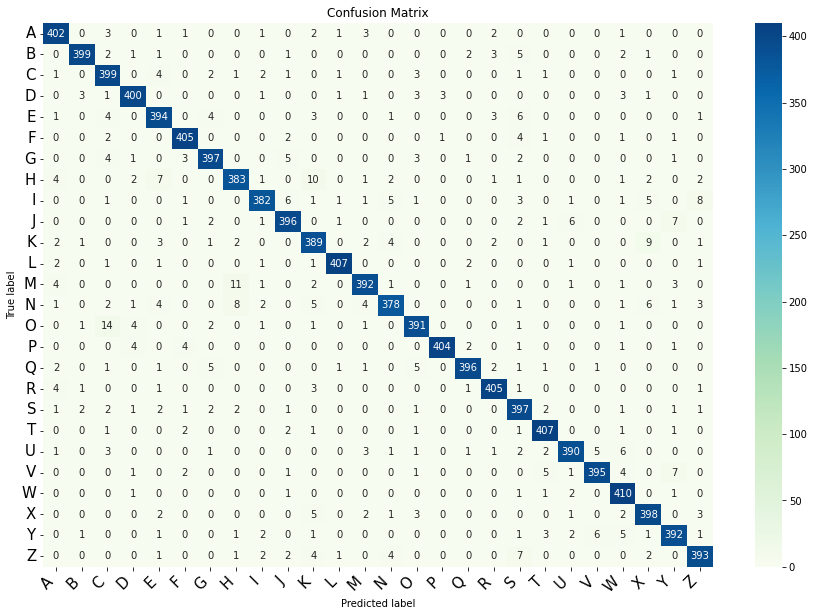

In [7]:
plt.figure(figsize=(15, 10))
class_names = list(label2chars.values())
df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names).astype(int)
heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap = 'GnBu')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=15)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
report = pd.DataFrame(classification_report(y_true, y_pred, target_names=class_names, output_dict=True))
print(report)
plt.show()
# plt.clf()
# plt.close()

In [2]:
with initialize(version_base=None, config_path="src/conf"):
    cfg = compose(config_name = "config.yaml", overrides=["method=T3_style", "label_request=style", "model.num_classes=4"])
    print(cfg)

{'method': 'T3_style', 'seed': 777, 'batch_size': 4, 'lr': 0.0001, 'epoch': 50, 'root_dir': '../data/fonts/', 'ref_file': 'google_font_category_v4.csv', 'label_request': 'style', 'filter': 'large', 'lim': 2838, '_fold': 0, 'cuda': 0, 'logs': 'logs', 'patience': 10, 'model': {'name': 'T3', 'font_dim': 100, 'word_size': 5, 'num_classes': 4, 'embed_dim': 100, 'nhead': 5, 'dim_feedforward': 1024, 'depth': 6, 'dropout': 0.1, 'pool': 'cls'}}


In [3]:
cwd = Path(os.getcwd())
train_loader, val_loader, test_loader = get_loader(cfg, cwd)
# set device
device = torch.device('cuda:' + str(cfg.cuda)) if torch.cuda.is_available() else torch.device('cpu')
np.random.seed(cfg.seed)
torch.manual_seed(cfg.seed)
if device == 'cuda':
    torch.cuda.manual_seed(cfg.seed)
# set model
model = T3(
    font_dim=cfg.model.font_dim,
    word_size=cfg.model.word_size,
    num_classes=cfg.model.num_classes,
    embed_dim=cfg.model.embed_dim,
    depth=cfg.model.depth,
    heads=cfg.model.nhead,
    mlp_dim=cfg.model.dim_feedforward,
    dropout=cfg.model.dropout,
    emb_dropout=cfg.model.dropout,
    pool=cfg.model.pool
)
model_PATH = Path('./models/T3_style/epoch00049.pt')

In [4]:
model.load_state_dict(torch.load(model_PATH))
model.eval()
model.to(device)
confusion_matrix = np.zeros((cfg.model.num_classes, cfg.model.num_classes))
num_style = [i for i in range(4)]
styles = ['SANS_SERIF', 'HANDWRITING', 'DISPLAY', 'SERIF']
label2style = dict(zip(num_style, styles))
trueclasses = []
predclasses = []
inputsdata = []
with torch.no_grad():
    for inputs, classes in tqdm(test_loader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        inputsdata.append(inputs.to(device='cpu').detach().numpy().copy())
        trueclasses.append(classes.to(device='cpu').detach().numpy().copy())
        predclasses.append(preds.to(device='cpu').detach().numpy().copy())
        for t, p in zip(classes.view(-1), preds.view(-1)):
            confusion_matrix[t.long(), p.long()] += 1

y_true = [j for i in trueclasses for j in i.tolist()]
y_pred = [j for i in predclasses for j in i.tolist()]

100% 2711/2711 [00:14<00:00, 190.25it/s]


            SANS_SERIF  HANDWRITING      DISPLAY        SERIF  accuracy  \
precision     0.831249     0.652968     0.535036     0.906638  0.805018   
recall        0.933671     0.589286     0.455407     0.861740  0.805018   
f1-score      0.879488     0.619495     0.492020     0.883619  0.805018   
support    4342.000000   728.000000  1794.000000  3978.000000  0.805018   

              macro avg  weighted avg  
precision      0.731473      0.797925  
recall         0.710026      0.805018  
f1-score       0.718656      0.799433  
support    10842.000000  10842.000000  


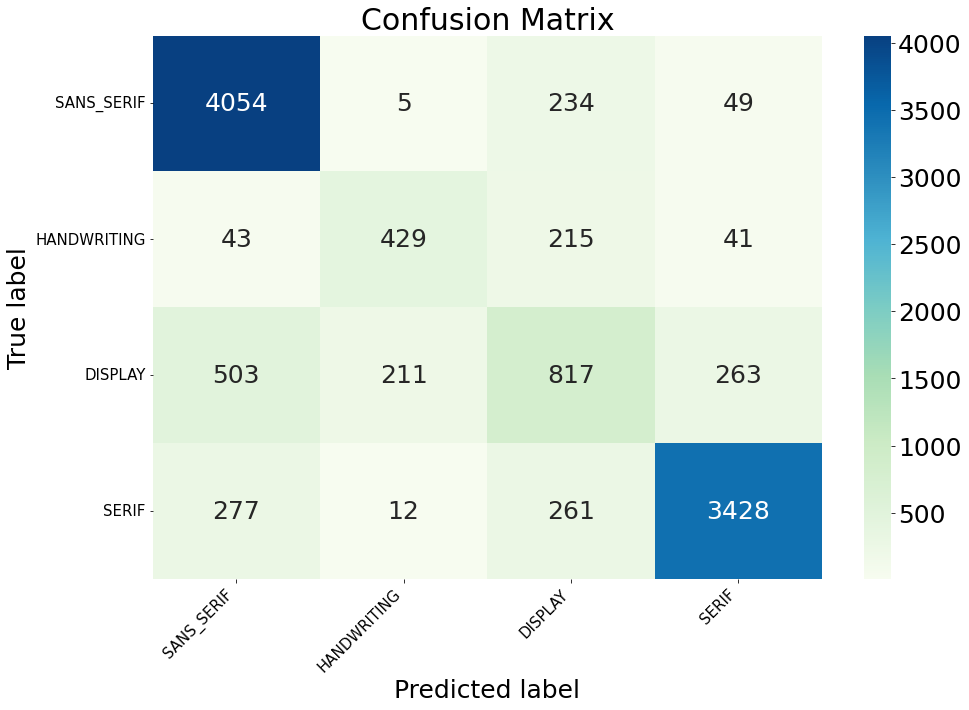

In [6]:
plt.rcParams["font.size"] = 25 # 全体のフォントサイズが変更されます。
plt.figure(figsize=(15, 10))
class_names = list(label2style.values())
df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names).astype(int)
heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap = 'GnBu')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=15)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
report = pd.DataFrame(classification_report(y_true, y_pred, target_names=class_names, output_dict=True))
print(report)
plt.show()
# plt.clf()
# plt.close()